# Portfolio Optimization in Python

## Table of Content:
* [1. Introduction](#intro)
* [2. Data Preparation](#data_prep)
* [3. Portfolio Optimization](#port_opt)
    * [3.1 Expected Return and Covariance Matrix](#step1)
    * [3.2 Computing Optimal Weights](#step2)
    * [3.3 Backtesting in Rolling Windows](#step3)
* [4. Performance Evaluation](#evaluation)
* [5. Limitation on Optimization](#limitation)
    * [5.1 Robustness on the Expected Returns Estimates](#5_1)
    * [5.2 Robustness on the Covariance Matrix](#5_2)
* [6. Appendix - Backtesting with FTSE100 Constituents](#appendix)
    * [6.1 Download Data from Yahoo Finance](#6_1)
    * [6.2 Load and Prepare Data](#6_2)
    * [6.3 Run Backtesting and Evaluate the Performance](#6_3)

## 1. Introduction <a class="anchor" id="intro"></a>

Portfolio optimization is a fundamental concept in investment management, aimed at constructing an optimal portfolio that balances risk and return to achieve the investor's objectives.

It involves selecting the appropriate weight of assets to maximize returns while minimizing risk, considering factors such as asset correlations, expected returns, and constraints.

## 2. Data Preparation <a class="anchor" id="data_prep"></a>

This analysis focuses specifically on the period from January 2013 to February 2024 and covers 5 specific industries (Beer, Health, Finance, Retail, Wholesale).

In [84]:
# import libraries
import numpy as np
import pandas as pd

import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
# load industry list
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
# filter industries
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
# load industry returns
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2013":]
# load industry market caps
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2013":]

## 3. Portfolio Optimization <a class="anchor" id="port_opt"></a>

 This section will will illustrate the procedural steps involved in optimizing a portfolio using the efficient frontier, under the premise of a simplistic assumption that expected returns and covariance will remain constant in the future. Furthermore, it will conclude by outlining the methodology for backtesting this approach within a rolling window framework.

### 3.1 Expected Return and Covariance Matrix <a class="anchor" id="step1"></a>

Expected returns and the covariance matrix play pivotal roles in constructing the efficient frontier.

- Expected returns quantify the average return that an asset is expected to generate over a specified period, providing insight into the potential rewards of an investment.

- Meanwhile, the covariance matrix captures the relationships between the returns of different assets in the portfolio, indicating how they move together or diverge. 

Expected returns are computed utilizing the `annualize_rets()` function within the erk module. To annualize a return over a certain period, one compounds the return for the number of periods in a year. In this project, to annualize a monthly return, the return is compounded 12 times. The formula to annualize a monthly return, denoted as $R_m$, is as follows:

$$ (1+R_m)^{12} - 1$$

In [9]:
# calculate annualized returns
rets = ind_rets["2014":][inds]
annualized_rets = erk.annualize_rets(rets, 12)
annualized_rets.head()

Beer     0.099604
Hlth     0.062150
Fin      0.124864
Rtail    0.140260
Whlsl    0.117608
dtype: float64

By inputting the monthly returns of different industries into the built-in `cov()` function, we can derive the covariance matrix, which quantifies the degree of linear association between the returns of each industry pair (i.e. company x and company y). The formula to generate a covariance matrix, denoted as $cov_{x, y}$ is as follows:

$$cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$$

In [10]:
# calculate covariance matrix
cov = rets.cov()
cov

,Beer,Hlth,Fin,Rtail,Whlsl
Beer,0.001612,0.001165,0.001124,0.001078,0.001264
Hlth,0.001165,0.003728,0.002461,0.002123,0.002303
Fin,0.001124,0.002461,0.003565,0.002046,0.002480
Rtail,0.001078,0.002123,0.002046,0.002729,0.001914
Whlsl,0.001264,0.002303,0.002480,0.001914,0.002608


### 3.2 Computing Optimal Weights <a class="anchor" id="step2"></a>

The efficient frontier is a key concept in portfolio optimization, which also known as Markowitz procedure. It represents the set of portfolios with optimal weights that offer the highest expected return for a given level of risk, or the lowest risk for a given level of return.

By considering both the expected returns and the covariance matrix of the assets, the Markowitz procedure identifies the optimal asset allocation that lies on the efficient frontier—a curve representing the set of portfolios that offer the best risk-return trade-offs with Shape Ratio as measure.

$${Sharpe Ratio}_p = \frac{E(R_{p})-Risk Free Rate}{\sigma_{p}}$$

This section computes the weights for the MSR (Max Sharpe Ratio) portfolio, GMV (Global Minimum Variance) portfolio, and the Equal Weighted (EW) portfolio, subsequently plotting them on the efficient frontier for comparison.

In [14]:
# get the weights of the maximum sharpe ratio portfolio
erk.msr(0.02, annualized_rets, cov).round(2)

array([0.43, 0.  , 0.05, 0.52, 0.  ])

To obtain the MSR portfolio, the optimal weights are 43% in Beer industry, 5% in Finance industry and 52% in Retail industry.

In [15]:
# get the weights of the global minimum variance portfolio
erk.gmv(cov).round(2)

array([0.73, 0.02, 0.06, 0.19, 0.  ])

To obtain the GMV portfolio, the optimal weights are 73% in Beer industry, , 2% in Health industry, 6% in Finance industry and 19% in Retail industry.

By inputting the expected return and covariance matrix calculated above, efficient frontier can be plotted with the `plot_ef` function in the erk module. The graph will display with 3 types of portfolio:

- Max Sharpe Ratio (MSR) portfolio (green) - maximizes the risk-adjusted return

- Global Minmum Variance (GMV) portfolio (blue) - minimizes portfolio variance 

- Equal Weighted (EW) portfolio (yellow) - distributes equal weights to all assets

<Axes: xlabel='Volatility'>

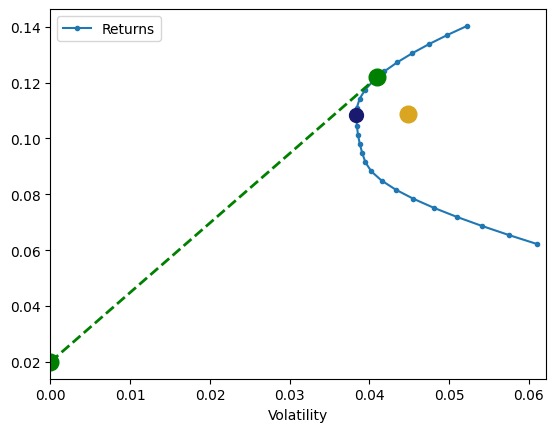

In [11]:
# plot efficient frontier with 25 points
erk.plot_ef(25, annualized_rets, cov, show_cml=True, riskfree_rate=0.02, show_ew=True, show_gmv=True)

### 3.3 Backtesting in Rolling Windows <a class="anchor" id="step3"></a>

In this section we'll develop a basic infrastructure to backtest various portfolio construction techniques and compare them with a rolling window of 1 year (12 months).

1. Equally weighted and Cap Weighted portfolios will be constructed with simple weight-optimizers (`weight_ew` and `weight_cw` in erk module) as there are no Covariance estimates required for their weighting schemes.

2. To calculate the MSR and GMV portfolio, `minimize` function in scipy.optimize library is leverage to use as an optimizer to calculate the optimal weight of portfolio with maximum sharpe ratio and lowest volatility. This function is implemented in the `msr` function in erk module.

3. Risk-parity portfolio has equal risk contribution among the assets, `minimize` function in scipy.optimize library is used to generate the weights that minimize the total squared difference in risk contribution. This function is implemented in the `target_risk_contributions` function in erk module.

In [29]:
# backtest equal weighted portfolio
ewr = erk.backtest_ws(ind_rets, estimation_window=12, weighting=erk.weight_ew)
# backtest cap weighted portfolio
cwr = erk.backtest_ws(ind_rets, estimation_window=12, weighting=erk.weight_cw, cap_weights=ind_mcap)
# backtest risk parity portfolio
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=12, weighting=erk.weight_erc, cov_estimator=erk.sample_cov)
# backtest global minimum variance portfolio
gmv_w_r = erk.backtest_ws(ind_rets, estimation_window=12, weighting=erk.weight_gmv)
# backtest maximum sharpe ratio portfolio
msr_w_r = erk.backtest_ws(ind_rets, estimation_window=12, weighting=erk.weight_msr)

## 4. Performance Evaluation <a class="anchor" id="evaluation"></a>

This section will retrieve the results from the above backtesting, consolidate them into a dataframe, and compare various weighting schemes using different performance metrics.


Conditional Value at Risk (CVaR), 
It is also known as Expected Shortfall (ES), is a risk measure that quantifies the potential losses beyond a specified confidence level. Unlike Value at Risk (VaR), which provides an estimate of the maximum loss within a certain probability level (percentile), CVaR considers the expected value (mean) of losses exceeding the VaR threshold. It provides a more comprehensive assessment of downside risk by taking into account the severity of losses beyond the VaR threshold.

Cornish-Fisher VaR
It is a modification of VaR that adjusts for skewness and kurtosis in the return distribution. Traditional VaR calculations assume that asset returns follow a normal distribution, which may not always be the case in practice. The Cornish-Fisher approach accounts for deviations from normality by adjusting the z-score used in VaR calculations based on the skewness and kurtosis of the return distribution. This adjustment provides a more accurate estimate of the potential downside risk, particularly in the presence of non-normal return distributions. The adjusted z-score which we'll call $z_{cornishfisher}$ given by:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.103686,0.168151,-0.310484,4.276314,0.073019,0.098798,0.426312,-0.259299
CW,0.120857,0.157945,-0.313128,3.822911,0.067306,0.093052,0.559708,-0.247823
ERC-Sample,0.099788,0.157300,-0.337692,4.318327,0.068439,0.092603,0.431629,-0.237088
GMV,0.107496,0.149386,0.159798,3.727779,0.058582,0.077595,0.504747,-0.189616
MSR,0.116508,0.201218,0.202856,4.631214,0.078988,0.115372,0.418204,-0.253134


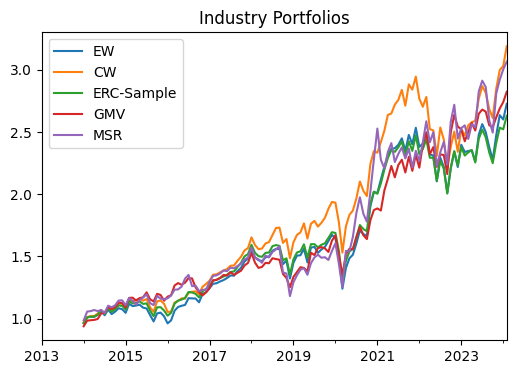

In [30]:
# present backtest results
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r, "GMV": gmv_w_r, "MSR": msr_w_r})
(1+btr).cumprod().plot(figsize=(6,4), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Here's an analysis of the results:

1. Annualized Return: The highest annualized return is observed for the CW (Capital Weighted) portfolio at 12.09%, followed closely by the MSR (Max Sharpe Ratio) portfolio at 11.65%. The EW (Equal Weighted) portfolio has the lowest annualized return at 10.37%.

2. Annualized Volatility: The GMV (Global Minimum Variance) portfolio has the lowest annualized volatility at 14.94%, indicating lower risk compared to other portfolios. Conversely, the MSR portfolio exhibits the highest volatility at 20.12%.

3. Skewness and Kurtosis: Skewness measures the asymmetry of return distribution, and kurtosis indicates the tails' thickness. Generally, lower skewness and kurtosis values are preferred. Among the portfolios, the ERC-Sample portfolio has the lowest skewness and kurtosis values, indicating a more symmetric and normally distributed return profile.

4. Cornish-Fisher VaR (5%) and Historic CVaR (5%): These metrics quantify the portfolio's risk of extreme losses. Lower values are desirable for risk management. The GMV portfolio has the lowest Cornish-Fisher VaR and Historic CVaR values, indicating lower risk of extreme losses compared to other portfolios.

5. Sharpe Ratio: The Sharpe Ratio measures the risk-adjusted return, with higher values indicating better risk-adjusted performance. The CW portfolio has the highest Sharpe Ratio at 0.56, suggesting it provides the best risk-adjusted return among the portfolios.

6. Max Drawdown: This metric measures the maximum loss from a peak to a trough in the portfolio's value over a specific period. Lower values indicate better resilience during market downturns. The GMV portfolio has the lowest maximum drawdown, indicating better downside protection compared to other portfolios.

## 5. Limitation on Optimization <a class="anchor" id="limitation"></a>

### 5.1 Robustness on the Expected Returns Estimates <a class="anchor" id="5_1"></a>

Estimates for expected returns in portfolio optimization often lack robustness due to their sensitivity to input parameters and the inherent uncertainty in forecasting future returns. Traditional approaches rely on historical data or analyst forecasts, which may be subject to biases, errors, and changes in market conditions. As a result, the resulting portfolios may be overly sensitive to these estimates, leading to suboptimal outcomes and increased volatility. 

To address this challenge, the Black-Litterman model offers a more robust framework by combining market equilibrium views with investor-specific beliefs. This approach incorporates a blend of historical data, market expectations, and investor preferences to generate more stable and reliable estimates of expected returns. By incorporating a Bayesian updating process, the Black-Litterman model provides a systematic way to incorporate new information and adjust portfolio allocations dynamically, mainly with below 2 steps:

1. Extracting Implied Expected Returns (as an anchor point): this is a reverse-optimization step that infers the implied returns vector $\pi$ that are implied by the equilibrium weights $w$ using the formula:

$$\pi = \delta\Sigma w$$

2. Introducing Active Views: it is expressed as a normal distribution with mean equal to $Q$ and a standard deviation given by $\omega$

$$P_{\mu}= Q + \epsilon^{v}$$

where Q represents vector of mean values for expected returns on assets, Ω matrix represents error or confidence levels for views (from active managers)

More details of the model can be referenced to the paper ""The Intuition Behind Black-Litterman Model Portfolios" (He and Litterman, 2002).

### 5.2 Robustness on the Covariance Matrix <a class="anchor" id="5_2"></a>


The above portfolio utilizes a covariance matrix estimator based on sample risk, which may lead to estimation bias. An alternative approach is the constant correlation estimator, which derives the covariance matrix by averaging correlations $\rho$ from the sample correlation matrix (with below formula). However, this method introduces exposure to model risk.

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$

A balanced solution is statistical shrinkage, which blends model and sample estimates through a shrinkage parameter selection. It's typical for practitioners to opt for a shrinkage value $\delta$ of 0.5 as an optimal compromise.

## 6. Appendix: Backtesting with FTSE100 Constituents <a class="anchor" id="appendix"></a>

This section aims to expand the scope of the project by applying portfolio optimization techniques to the UK market, focusing on the period from May 2019 to April 2024, spanning a five-year timeframe. The analysis will utilize data from FTSE 100 constituents as input. Multiple portfolios employing different weighting schemes will be constructed, and their performance will be evaluated using above performance metrics.

### 6.1 Download Data from Yahoo Finance <a class="anchor" id="6_1"></a>

In [1]:
import ftse100_data_extraction as ftsede # module to download data

# get ftse100 symbols and download data
ftse_symbols = ftsede.get_ftse100_symbols()
start_date = '2019-05-01'
end_date = '2024-04-30'
output_file = 'ftse100_2019_2024.csv'
 
ftsede.download_stock_data(ftse_symbols, start_date, end_date, output_file)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AV..L']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BA..L']: Exception('%ticker%: No timezone found, symbo

No columns with NA values.


### 6.2 Load and Prepare Data <a class="anchor" id="6_2"></a>

In [116]:
import pandas as pd

# load ftse100 data
ftse_df = pd.read_csv('data/ftse100_2019_2024.csv', index_col = 'Date')
ftse_df.head()

,III.L,ADM.L,AAF.L,AAL.L,ANTO.L,AHT.L,ABF.L,AZN.L,AUTO.L,AV..L,...,STJ.L,TW..L,TSCO.L,ULVR.L,UU..L,UTG.L,VOD.L,WEIR.L,WTB.L,WPP.L
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,904.428528,1882.420166,0.0,1582.565186,755.240906,1971.044800,2373.334229,4979.887207,541.644714,0.0,...,918.959900,0.0,217.128220,3886.490479,0.0,843.072632,93.895386,1553.182983,3661.146484,798.799683
2019-05-02,900.216064,1864.516724,0.0,1552.408691,740.275574,1957.991821,2372.399658,5018.710449,541.075073,0.0,...,918.959900,0.0,214.877319,3882.227783,0.0,850.667847,93.828865,1531.188599,3625.135254,802.757446
2019-05-03,898.109863,1857.696045,0.0,1588.660645,747.247986,1968.247681,2382.674072,5065.474121,546.770569,0.0,...,919.776733,0.0,214.184708,3893.647217,0.0,846.646851,93.176918,1543.823608,3644.341553,806.385376
2019-05-07,890.948425,1824.446899,0.0,1558.825073,725.480103,1899.252197,2365.861572,5084.884766,545.062073,0.0,...,913.650391,0.0,213.838394,3885.187500,0.0,843.519409,93.136993,1510.598022,3621.134033,795.666565
2019-05-08,890.948425,1817.626709,0.0,1550.484009,727.520813,1916.034790,2359.323975,5148.413086,547.150452,0.0,...,909.157776,0.0,210.808319,3915.640137,0.0,841.285522,93.203522,1527.444824,3627.536133,801.108398


The code drops columns containing more than 10 zeros as they likely provide insignificant information. For columns with fewer than 10 zeros, forward fill is applied to minimize data loss. However, it's essential to acknowledge that this approach may introduce estimation errors.

In [117]:
import numpy as np
# Find columns with more than 10 zeros
zero_counts = (ftse_df == 0).sum()
columns_to_drop = zero_counts[zero_counts > 10].index

# Drop columns and forward fill missing values
ftse_df = ftse_df.drop(columns_to_drop, axis=1)

# Find columns with zeros
zero_columns = ftse_df.columns[ftse_df.eq(0).any()]

# Forward fill zeros
ftse_df[zero_columns] = ftse_df[zero_columns].replace(0, method='ffill')


/var/folders/nj/qmb1hkys4r3_9w675m808z0c0000gn/T/ipykernel_1945/1437130823.py:13: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  ftse_df[zero_columns] = ftse_df[zero_columns].replace(0, method='ffill')


In [118]:
# check if there are any columns with zeros
zero_counts = (ftse_df == 0).sum()
columns_with_zeros = zero_counts[zero_counts > 0].index

if len(columns_with_zeros) > 0:
    print("The following columns still contain zeros:")
    print(columns_with_zeros)
else:
    print("No columns contain zeros.")

No columns contain zeros.


In [120]:
# Convert the index of ftse_df to datetime
ftse_df.index = pd.to_datetime(ftse_df.index)

# Resample the data to monthly frequency
ftse_df_monthly = ftse_df.resample('M').last()
ftse_df_monthly.head()


/var/folders/nj/qmb1hkys4r3_9w675m808z0c0000gn/T/ipykernel_1945/3551563535.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ftse_df_monthly = ftse_df.resample('M').last()


,III.L,ADM.L,AAL.L,ANTO.L,AHT.L,ABF.L,AZN.L,AUTO.L,BME.L,BARC.L,...,SSE.L,STAN.L,STJ.L,TSCO.L,ULVR.L,UTG.L,VOD.L,WEIR.L,WTB.L,WPP.L
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-31,885.472168,1771.576172,1519.846313,665.618652,1738.883179,2305.151123,5146.647949,568.983215,236.169312,128.131836,...,809.857056,611.532776,854.836914,199.358093,4091.585205,848.434021,86.098495,1375.823608,3760.399658,776.042847
2019-06-30,955.929993,1897.012695,1800.155273,790.443481,2101.577637,2311.296631,5680.459473,520.001648,226.493851,128.526505,...,842.521667,635.744812,896.904968,199.622284,4140.225098,870.772949,88.807640,1447.422485,3759.587402,848.028748
2019-07-31,955.071411,1861.787231,1635.338623,798.606506,2119.293213,2270.945312,6230.151855,514.306152,251.433380,132.198700,...,877.761963,602.453308,803.783569,196.628342,4191.823730,922.152649,103.064095,1401.093628,3673.496094,831.071533
2019-08-31,941.335632,1844.604004,1465.350830,736.364075,2152.242676,2131.122314,6522.763184,509.075775,243.142838,119.633652,...,918.040955,559.924194,764.909119,193.018051,4428.793945,935.555847,106.607605,1370.675781,3551.669189,830.900269
2019-09-30,1001.430054,1838.291016,1545.465210,772.204590,2145.608398,2161.151611,6471.957520,488.390961,257.821045,131.719620,...,993.414368,615.916687,816.247559,212.214233,4167.976074,985.284668,111.249908,1334.174438,3487.506592,871.837219


In [127]:
# calculating daily returns and drop NaN values
ftse_rets = ftse_df_monthly.pct_change().dropna()
ftse_rets.head()

,III.L,ADM.L,AAL.L,ANTO.L,AHT.L,ABF.L,AZN.L,AUTO.L,BME.L,BARC.L,...,SSE.L,STAN.L,STJ.L,TSCO.L,ULVR.L,UTG.L,VOD.L,WEIR.L,WTB.L,WPP.L
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-30,0.079571,0.070805,0.184432,0.187532,0.208579,0.002666,0.103720,-0.086086,-0.040968,0.003080,...,0.040334,0.039592,0.049212,0.001325,0.011888,0.026330,0.031466,0.052041,-0.000216,0.092760
2019-07-31,-0.000898,-0.018569,-0.091557,0.010327,0.008430,-0.017458,0.096769,-0.010953,0.110111,0.028572,...,0.041827,-0.052366,-0.103825,-0.014998,0.012463,0.059005,0.160532,-0.032008,-0.022899,-0.019996
2019-08-31,-0.014382,-0.009229,-0.103947,-0.077939,0.015547,-0.061570,0.046967,-0.010170,-0.032973,-0.095047,...,0.045888,-0.070593,-0.048364,-0.018361,0.056532,0.014535,0.034382,-0.021710,-0.033164,-0.000206
2019-09-30,0.063840,-0.003422,0.054672,0.048672,-0.003082,0.014091,-0.007789,-0.040632,0.060369,0.101025,...,0.082102,0.100000,0.067117,0.099453,-0.058891,0.053154,0.043546,-0.026630,-0.018065,0.049268
2019-10-31,-0.033005,-0.045326,0.059000,-0.035373,0.037102,-0.033435,0.033053,0.102353,-0.023985,0.115692,...,0.030510,0.024554,0.062896,-0.012554,-0.047381,0.030220,-0.028395,-0.043576,-0.054262,-0.031470


### 6.3 Run Backtesting and Evaluate the Performance <a class="anchor" id="6_3"></a>

Considering that the dataset comprises daily data, an estimation window of 252 days is established to conduct backtesting on an annual basis.

In [125]:
# backtest equal weighted portfolio of ftse100 data
ewr_ftse = erk.backtest_ws(ftse_rets, estimation_window=12, weighting=erk.weight_ew)
# backtest risk parity portfolio of ftse100 data
mv_erc_r_ftse = erk.backtest_ws(ftse_rets, estimation_window=12, weighting=erk.weight_erc, cov_estimator=erk.sample_cov)
# backtest global minimum variance portfolio of ftse100 data
gmv_w_r_ftse = erk.backtest_ws(ftse_rets, estimation_window=12, weighting=erk.weight_gmv)
# backtest maximum sharpe ratio portfolio of ftse100 data
msr_w_r_ftse = erk.backtest_ws(ftse_rets, estimation_window=12, weighting=erk.weight_msr)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.130392,0.157611,0.549167,3.242786,0.055282,0.066510,0.619800,-0.186752
ERC-Sample,0.115629,0.131960,0.192070,2.899124,0.050121,0.060407,0.631441,-0.166608
GMV,0.122141,0.135647,0.009826,3.126727,0.053120,0.063868,0.661002,-0.127681
MSR,0.105954,0.150670,-0.038424,2.789750,0.062081,0.077676,0.490478,-0.180055


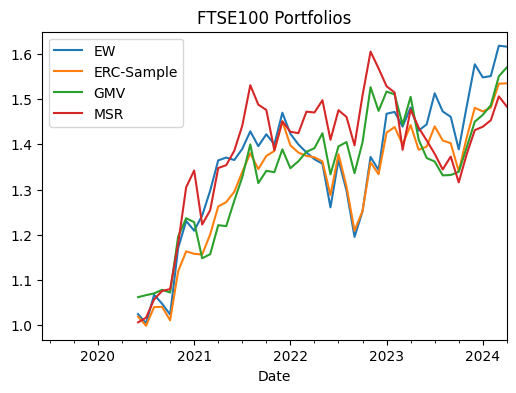

In [126]:
# present backtest results on ftse100 data
btr_ftse = pd.DataFrame({"EW": ewr_ftse, "ERC-Sample": mv_erc_r_ftse, "GMV": gmv_w_r_ftse, "MSR": msr_w_r_ftse})
(1+btr_ftse).cumprod().plot(figsize=(6,4), title="FTSE100 Portfolios")
erk.summary_stats(btr_ftse.dropna())

Here's an analysis of the results:

1. Annualized Return: The EW portfolio achieves the highest annualized return at 13.04%, followed by the ERC-Sample portfolio at 11.56% and the GMV portfolio at 12.21%. The MSR portfolio exhibits the lowest annualized return at 10.60%.

2. Annualized Volatility: The GMV portfolio demonstrates the lowest annualized volatility at 13.56%, indicating effective risk management. The ERC-Sample portfolio follows closely with 13.20%, while the EW portfolio and the MSR portfolio exhibit higher volatility at 15.76% and 15.07% respectively.

3. Skewness and Kurtosis: Among the portfolios, the EW portfolio demonstrates positive skewness (0.549) and high kurtosis (3.24), indicating a distribution skewed towards positive returns with fatter tails. The ERC-Sample and GMV portfolios display positive skewness and moderate kurtosis, while the MSR portfolio shows negative skewness and slightly lower kurtosis, implying more frequent negative returns and thinner tails.

4. Cornish-Fisher VaR (5%) and Historic CVaR (5%): The GMV portfolio exhibits the lowest Cornish-Fisher VaR and Historic CVaR values, indicating superior downside protection. The other portfolios also demonstrate relatively low VaR and CVaR values, with the MSR portfolio showing slightly higher risk levels compared to others.

5. Sharpe Ratio: The GMV portfolio achieves the highest Sharpe Ratio at 0.66, indicating the most efficient risk-adjusted return among the portfolios. The ERC-Sample portfolio follows closely with 0.63, while the EW and MSR portfolios exhibit lower Sharpe Ratios at 0.62 and 0.49 respectively.

6. Max Drawdown: The GMV portfolio experiences the lowest maximum drawdown at -12.77%, indicating better resilience during market downturns. The other portfolios also demonstrate relatively low maximum drawdowns, with the MSR portfolio experiencing the highest at -18.01%.